## Convolutional classifier

In [1]:
%matplotlib inline

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import noise
import MotionClouds as mc

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [5]:
from LogGabor import LogGabor

In [6]:
#import SLIP for whitening and PIL for resizing
import SLIP
import PIL
whit = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

## Noise stuff

In [7]:
def MotionCloudNoise(sf_0=0.125, B_sf=3., alpha = .5):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha= alpha)
    
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))
    return z, env


### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

In [8]:
# TODO: passer les arguments par la ligne de commande
N_theta = 6
N_azimuth = 16
N_eccentricity = 8
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [9]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                psi = i_azimuth * np.pi * 2 / N_azimuth
                theta_ref = i_theta*np.pi/N_theta
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos(psi)
                y = N_Y/2 + r * np.sin(psi)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': theta_ref + psi, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel() * ecc

    return retina


#### Full encoding

In [10]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 16, 8, 2, 16384)


In [11]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1536, 16384)


In [12]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1536)


#### Orientation invariant power encoding (colliculus??)

In [13]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 8, 16384)


In [14]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(128, 16384)


In [15]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 128)


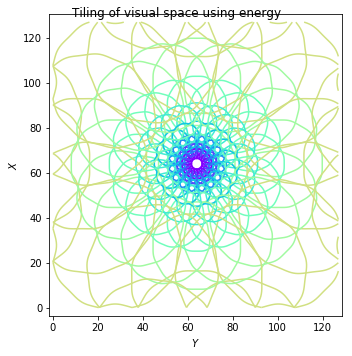

In [16]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

#### MNIST dataset read out

In [17]:
def get_data_loader(batch_size=100, train=True):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True)
    return data_loader


In [18]:
loader = get_data_loader(batch_size=1, train = False)

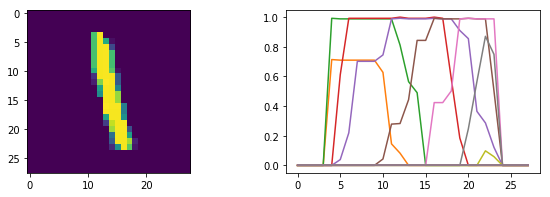

In [19]:
data, label = next(iter(loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:])

### From MNIST encoding

#### Input vectors encoding

In [24]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=128, CONTRAST=1., NOISE = 1., sf_0 = 0.1, B_sf = 0.1):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= CONTRAST
    data_fullfield += 0.5

    if NOISE>0.:
        im_noise, _ = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf)
        im_noise = NOISE *  im_noise
        #data_fullfield += im_noise #randomized_perlin_noise() #
        indices_data = np.where(data_fullfield > data_fullfield.mean())
        im_noise[indices_data] = data_fullfield[indices_data]
        data_fullfield = im_noise
        
    whit.set_size((N_pic,N_pic))
    data_fullfield = whit.whitening(data_fullfield)

    data_retina = retina_vector @ np.ravel(data_fullfield)
    
    tensor_retina = data_retina.reshape(N_theta, N_azimuth, N_eccentricity, N_phase)
    slice1 = tensor_retina[N_theta - 1,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    slice2 = tensor_retina[0,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    tensor_retina = np.concatenate ((slice1, tensor_retina, slice2), axis = 0)
    tensor_retina = np.transpose(tensor_retina,(3,0,1,2))

    return data_retina, tensor_retina, data_fullfield

#### Utilitaires

In [25]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

# Hyperparameters

In [36]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-3 #0.05

OFFSET_STD = 15 #0 #
OFFSET_MAX = 30 #0 #
NOISE = 0 #1 #
CONTRAST = 1 #0.3 #
sf_0 = 0.2
B_sf = 0.3

### Test

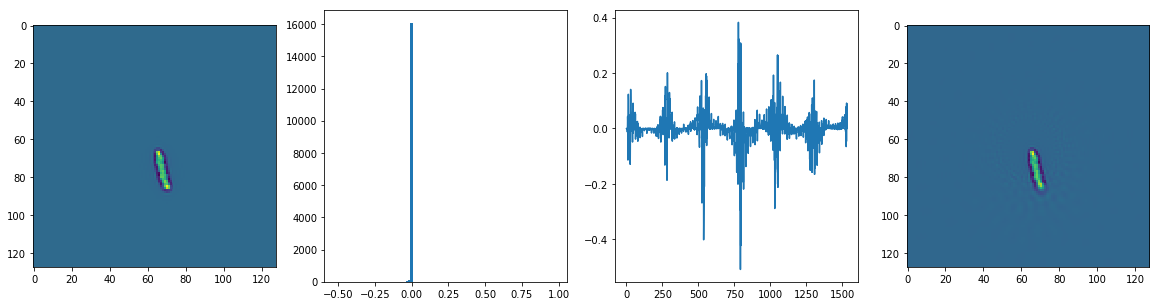

In [37]:
if True:
    i = 0
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    retina, _, image = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                    sf_0 = sf_0, B_sf = B_sf)
    #plt.imshow(input_test)
    plt.figure(figsize = (20,5))
    plt.subplot(141)
    plt.imshow(image)
    plt.subplot(142)
    f = plt.hist(image.flatten(),100)
    plt.subplot(143)
    f = plt.plot(retina)
    plt.subplot(144)
    im = retina_inverse @ retina
    plt.imshow(im.reshape(128, 128))


#### Torch stuff

In [38]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [39]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [40]:
BIAS_CONV = True
BIAS_DECONV = True #True

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        ## Convolution
        self.conv1 = nn.Conv3d(2, 16, 3, bias = BIAS_CONV, stride=1, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, bias = BIAS_CONV, stride=1, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, bias = BIAS_CONV, stride=1, padding=1)
        self.pool = nn.MaxPool3d(2, stride=2)
        
        # Bottleneck
        self.bn1= torch.nn.Linear(64 * 2 * 1, 100, bias = BIAS_DECONV)
        self.bn2 = torch.nn.Linear(100, 30, bias = BIAS_DECONV)
        self.bn3 = torch.nn.Linear(30, 10, bias = BIAS_DECONV)
        
        #self.dropout = nn.Dropout(p = 0.5) 
        
    def forward(self, image):
        
        # Convolution
        h_conv1 = F.relu(self.pool(self.conv1(image)))
        h_conv2 = F.relu(self.pool(self.conv2(h_conv1)))
        h_conv3 = F.relu(self.pool(self.conv3(h_conv2)))
        h_conv3_flat = h_conv3.view(-1, 64 * 2 * 1)
        h_bn1 = F.relu(self.bn1(h_conv3_flat))       
        h_bn1_drop = F.dropout(h_bn1, p = .5) #self.dropout)
        
        # Bottleneck
        h_bn2 = F.relu(self.bn2(h_bn1_drop)) #+self.hidden2(data) #+ 
        h_bn2_drop = F.dropout(h_bn2, p = .5) #self.dropout)
        z = self.bn3(h_bn2_drop)
        
        return z


In [41]:
net = Net()

In [42]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [43]:
loss_func = torch.nn.CrossEntropyLoss()

In [44]:
#### Training

In [45]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = 1, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        tensor_retina = np.zeros((minibatch_size, N_phase, N_theta + 2, N_azimuth, N_eccentricity))
        # target = np.zeros((minibatch_size, asize))

        for i in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            _, tensor_retina[i, :, :, :, :], _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                        CONTRAST = CONTRAST, NOISE = NOISE,
                                                        sf_0 = sf_0, B_sf = B_sf)
            

        tensor_retina, label = Variable(torch.FloatTensor(tensor_retina)), Variable(torch.LongTensor(label))
        prediction = net(tensor_retina)
        loss = loss_func(prediction, label)
        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx*minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
                                                        
    return net


In [46]:
def test(net, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    batch_size = label.shape[0]

    tensor_retina = np.zeros((batch_size, N_phase, N_theta + 2, N_azimuth, N_eccentricity))
    # target = np.zeros((minibatch_size, asize))

    for i in range(batch_size):
        i_offset = minmax(np.random.randn() * offset_std, offset_max)
        j_offset = minmax(np.random.randn() * offset_std, offset_max)
        _, tensor_retina[i, :, :, :, :], _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                                    sf_0 = sf_0, B_sf = B_sf)


    tensor_retina, label = Variable(torch.FloatTensor(tensor_retina)), Variable(torch.LongTensor(label))
    with torch.no_grad():
        output = net(tensor_retina)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        #pred = Variable(torch.LongTensor(pred))
        #print(pred.data.numpy())
        acc = pred.eq(label.view_as(pred)).sum().item()

    return acc / batch_size


## Central target, without noise

In [185]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.31141996383667 Time: 0.03 mn
[1000/60000] Loss: 2.302793264389038 Time: 0.30 mn
[2000/60000] Loss: 2.2968015670776367 Time: 0.58 mn
[3000/60000] Loss: 2.2562925815582275 Time: 0.85 mn
[4000/60000] Loss: 2.1389997005462646 Time: 1.14 mn
[5000/60000] Loss: 2.0291011333465576 Time: 1.42 mn
[6000/60000] Loss: 1.967401385307312 Time: 1.74 mn
[7000/60000] Loss: 1.9791663885116577 Time: 2.02 mn
[8000/60000] Loss: 1.7498445510864258 Time: 2.31 mn
[9000/60000] Loss: 1.6915044784545898 Time: 2.61 mn
[10000/60000] Loss: 1.4929088354110718 Time: 2.95 mn
[11000/60000] Loss: 1.5351307392120361 Time: 3.27 mn
[12000/60000] Loss: 1.1542962789535522 Time: 3.70 mn
[13000/60000] Loss: 1.0389820337295532 Time: 4.20 mn
[14000/60000] Loss: 0.8713935613632202 Time: 4.54 mn
[15000/60000] Loss: 0.8287798166275024 Time: 4.87 mn
[16000/60000] Loss: 0.9118800163269043 Time: 5.16 mn
[17000/60000] Loss: 0.6069009304046631 Time: 5.45 mn
[18000/60000] Loss: 0.7718057036399841 Tim

KeyboardInterrupt: 

## Anywhere target, without noise

In [48]:
# test ecc**2

In [49]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.299145460128784 Time: 0.05 mn
[1000/60000] Loss: 2.313236713409424 Time: 0.53 mn
[2000/60000] Loss: 2.3097898960113525 Time: 1.04 mn
[3000/60000] Loss: 2.292935848236084 Time: 1.54 mn
[4000/60000] Loss: 2.2909750938415527 Time: 2.05 mn
[5000/60000] Loss: 2.3140554428100586 Time: 2.56 mn
[6000/60000] Loss: 2.2864840030670166 Time: 3.08 mn
[7000/60000] Loss: 2.2727794647216797 Time: 3.62 mn
[8000/60000] Loss: 2.2969329357147217 Time: 4.18 mn
[9000/60000] Loss: 2.266347885131836 Time: 4.83 mn
[10000/60000] Loss: 2.1763315200805664 Time: 5.50 mn
[11000/60000] Loss: 2.1776208877563477 Time: 6.15 mn
[12000/60000] Loss: 2.128744125366211 Time: 6.82 mn
[13000/60000] Loss: 2.0696380138397217 Time: 7.49 mn
[14000/60000] Loss: 2.0889475345611572 Time: 8.18 mn
[15000/60000] Loss: 2.1411638259887695 Time: 8.84 mn
[16000/60000] Loss: 2.0568320751190186 Time: 9.53 mn
[17000/60000] Loss: 2.0251781940460205 Time: 10.17 mn
[18000/60000] Loss: 1.9315969944000244 Tim

KeyboardInterrupt: 

In [47]:
# ref

In [200]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.3046092987060547 Time: 0.03 mn
[1000/60000] Loss: 2.304769515991211 Time: 0.31 mn
[2000/60000] Loss: 2.2492403984069824 Time: 0.59 mn
[3000/60000] Loss: 2.2985072135925293 Time: 0.88 mn
[4000/60000] Loss: 2.280093193054199 Time: 1.17 mn
[5000/60000] Loss: 2.2939727306365967 Time: 1.46 mn
[6000/60000] Loss: 2.288900375366211 Time: 1.75 mn
[7000/60000] Loss: 2.2821719646453857 Time: 2.05 mn
[8000/60000] Loss: 2.285306930541992 Time: 2.35 mn
[9000/60000] Loss: 2.226299524307251 Time: 2.65 mn
[10000/60000] Loss: 2.2096524238586426 Time: 2.95 mn
[11000/60000] Loss: 2.1388399600982666 Time: 3.26 mn
[12000/60000] Loss: 2.1188266277313232 Time: 3.55 mn
[13000/60000] Loss: 2.0451300144195557 Time: 4.00 mn
[14000/60000] Loss: 2.0361926555633545 Time: 4.33 mn
[15000/60000] Loss: 1.9961262941360474 Time: 4.84 mn
[16000/60000] Loss: 2.1460046768188477 Time: 5.17 mn
[17000/60000] Loss: 2.049861192703247 Time: 5.66 mn
[18000/60000] Loss: 2.0551106929779053 Time:

[33000/60000] Loss: 0.8288421034812927 Time: 13.67 mn
[34000/60000] Loss: 0.7539103031158447 Time: 14.11 mn
[35000/60000] Loss: 0.6744822859764099 Time: 14.60 mn
[36000/60000] Loss: 0.8015787601470947 Time: 15.16 mn
[37000/60000] Loss: 0.8058461546897888 Time: 15.66 mn
[38000/60000] Loss: 0.9130987524986267 Time: 16.13 mn
[39000/60000] Loss: 0.8360981941223145 Time: 16.49 mn
[40000/60000] Loss: 0.5519980788230896 Time: 16.85 mn
[41000/60000] Loss: 0.7633460164070129 Time: 104.40 mn
[42000/60000] Loss: 1.032699465751648 Time: 104.80 mn
[43000/60000] Loss: 0.8166251182556152 Time: 105.18 mn
[44000/60000] Loss: 0.7302177548408508 Time: 105.50 mn
[45000/60000] Loss: 0.7415067553520203 Time: 105.82 mn
[46000/60000] Loss: 0.5930925011634827 Time: 106.15 mn
[47000/60000] Loss: 0.838441789150238 Time: 106.47 mn
[48000/60000] Loss: 0.8894004821777344 Time: 106.79 mn
[49000/60000] Loss: 0.6121637225151062 Time: 107.12 mn
[50000/60000] Loss: 0.6681667566299438 Time: 107.45 mn
[51000/60000] Loss: 

[4000/60000] Loss: 0.44193756580352783 Time: 1.28 mn
[5000/60000] Loss: 0.3898589015007019 Time: 1.59 mn
[6000/60000] Loss: 0.5494592785835266 Time: 1.90 mn
[7000/60000] Loss: 0.721966028213501 Time: 2.22 mn
[8000/60000] Loss: 0.6343802213668823 Time: 2.54 mn
[9000/60000] Loss: 0.6395174860954285 Time: 2.84 mn
[10000/60000] Loss: 0.6079407334327698 Time: 3.17 mn
[11000/60000] Loss: 0.4316069483757019 Time: 3.49 mn
[12000/60000] Loss: 0.6966257691383362 Time: 3.80 mn
[13000/60000] Loss: 0.6815383434295654 Time: 4.11 mn
[14000/60000] Loss: 0.717660129070282 Time: 4.42 mn
[15000/60000] Loss: 0.5317637920379639 Time: 4.73 mn
[16000/60000] Loss: 0.44893282651901245 Time: 5.03 mn
[17000/60000] Loss: 0.5169241428375244 Time: 5.35 mn
[18000/60000] Loss: 0.5088986158370972 Time: 5.66 mn
[19000/60000] Loss: 0.6509076952934265 Time: 5.97 mn
[20000/60000] Loss: 0.6572006344795227 Time: 6.27 mn
[21000/60000] Loss: 0.5598875284194946 Time: 6.58 mn
[22000/60000] Loss: 0.49620264768600464 Time: 6.89 m

[36000/60000] Loss: 0.4559559226036072 Time: 11.27 mn
[37000/60000] Loss: 0.572136402130127 Time: 11.58 mn
[38000/60000] Loss: 0.5966817736625671 Time: 11.89 mn
[39000/60000] Loss: 0.5069324374198914 Time: 12.20 mn
[40000/60000] Loss: 0.4726381301879883 Time: 12.52 mn
[41000/60000] Loss: 0.5992851257324219 Time: 12.83 mn
[42000/60000] Loss: 0.4351523518562317 Time: 13.14 mn
[43000/60000] Loss: 0.49956387281417847 Time: 13.45 mn
[44000/60000] Loss: 0.568438708782196 Time: 13.76 mn
[45000/60000] Loss: 0.5209024548530579 Time: 14.06 mn
[46000/60000] Loss: 0.4885792136192322 Time: 14.37 mn
[47000/60000] Loss: 0.2812217175960541 Time: 14.69 mn
[48000/60000] Loss: 0.660976231098175 Time: 15.00 mn
[49000/60000] Loss: 0.5670881867408752 Time: 15.31 mn
[50000/60000] Loss: 0.509103536605835 Time: 15.62 mn
[51000/60000] Loss: 0.4640827476978302 Time: 15.93 mn
[52000/60000] Loss: 0.3896041512489319 Time: 16.25 mn
[53000/60000] Loss: 0.41342899203300476 Time: 16.56 mn
[54000/60000] Loss: 0.63023078

In [205]:
FIC_NAME = "2019-02-12-anywhere-no-noise"
torch.save(net, FIC_NAME + '.npy')  

## Central target, with noise

In [171]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 1.546095609664917 Time: 0.05 mn
[1000/60000] Loss: 1.645542860031128 Time: 0.52 mn
[2000/60000] Loss: 1.5328428745269775 Time: 1.02 mn
[3000/60000] Loss: 1.5637179613113403 Time: 1.55 mn
[4000/60000] Loss: 1.4484378099441528 Time: 2.06 mn
[5000/60000] Loss: 1.4753564596176147 Time: 2.57 mn
[6000/60000] Loss: 1.4238839149475098 Time: 3.09 mn
[7000/60000] Loss: 1.4185832738876343 Time: 3.62 mn
[8000/60000] Loss: 1.5372092723846436 Time: 4.13 mn
[9000/60000] Loss: 1.5864278078079224 Time: 4.63 mn
[10000/60000] Loss: 1.4121956825256348 Time: 5.14 mn
[11000/60000] Loss: 1.3882436752319336 Time: 5.65 mn
[12000/60000] Loss: 1.5720129013061523 Time: 6.17 mn
[13000/60000] Loss: 1.4791215658187866 Time: 6.68 mn
[14000/60000] Loss: 1.2468537092208862 Time: 7.20 mn
[15000/60000] Loss: 1.4980838298797607 Time: 7.71 mn
[16000/60000] Loss: 1.3021457195281982 Time: 8.28 mn
[17000/60000] Loss: 1.428396463394165 Time: 8.86 mn
[18000/60000] Loss: 1.385209321975708 Tim

KeyboardInterrupt: 

In [172]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 0.7757126688957214 Time: 0.05 mn
[1000/60000] Loss: 0.8137826323509216 Time: 0.47 mn
[2000/60000] Loss: 0.774284839630127 Time: 0.90 mn
[3000/60000] Loss: 0.9031782746315002 Time: 1.36 mn
[4000/60000] Loss: 0.9846518635749817 Time: 1.80 mn
[5000/60000] Loss: 0.9019448161125183 Time: 2.25 mn
[6000/60000] Loss: 0.7568922638893127 Time: 2.70 mn
[7000/60000] Loss: 0.8272315263748169 Time: 3.20 mn
[8000/60000] Loss: 0.8951953649520874 Time: 3.87 mn
[9000/60000] Loss: 0.7758467197418213 Time: 4.45 mn
[10000/60000] Loss: 0.8644165992736816 Time: 4.94 mn
[11000/60000] Loss: 0.7113468050956726 Time: 5.48 mn
[12000/60000] Loss: 0.8983970880508423 Time: 5.94 mn
[13000/60000] Loss: 0.7581342458724976 Time: 6.39 mn
[14000/60000] Loss: 0.6516146063804626 Time: 6.87 mn
[15000/60000] Loss: 0.8809421062469482 Time: 7.39 mn
[16000/60000] Loss: 1.098759651184082 Time: 7.93 mn
[17000/60000] Loss: 0.6466288566589355 Time: 8.40 mn
[18000/60000] Loss: 0.6882744431495667 T

KeyboardInterrupt: 

## Anywhere target, with noise

#### Trial 2 : background noise

In [251]:
for epoch in range(30):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.1741459369659424 Time: 0.19 mn
[1000/60000] Loss: 2.2317581176757812 Time: 2.12 mn
[2000/60000] Loss: 2.229848623275757 Time: 3.72 mn
[3000/60000] Loss: 2.1713571548461914 Time: 5.61 mn
[4000/60000] Loss: 2.2171385288238525 Time: 7.40 mn
[5000/60000] Loss: 2.139853000640869 Time: 9.21 mn
[6000/60000] Loss: 2.1993391513824463 Time: 10.96 mn
[7000/60000] Loss: 2.2142274379730225 Time: 12.64 mn
[8000/60000] Loss: 2.2447474002838135 Time: 14.44 mn
[9000/60000] Loss: 2.2366528511047363 Time: 16.35 mn
[10000/60000] Loss: 2.1531319618225098 Time: 18.22 mn
[11000/60000] Loss: 2.1996002197265625 Time: 20.05 mn
[12000/60000] Loss: 2.2592639923095703 Time: 21.85 mn
[13000/60000] Loss: 2.236222743988037 Time: 23.59 mn
[14000/60000] Loss: 2.2016818523406982 Time: 25.26 mn
[15000/60000] Loss: 2.1837573051452637 Time: 27.03 mn
[16000/60000] Loss: 2.2948060035705566 Time: 28.99 mn
[17000/60000] Loss: 2.2343854904174805 Time: 30.92 mn
[18000/60000] Loss: 2.2360193

KeyboardInterrupt: 

In [ ]:
for epoch in range(30):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.2298009395599365 Time: 0.05 mn
[1000/60000] Loss: 2.224888563156128 Time: 0.62 mn
[2000/60000] Loss: 2.197838544845581 Time: 1.15 mn
[3000/60000] Loss: 2.2118496894836426 Time: 1.68 mn
[4000/60000] Loss: 2.206404209136963 Time: 2.22 mn
[5000/60000] Loss: 2.1555113792419434 Time: 2.75 mn
[6000/60000] Loss: 2.2388315200805664 Time: 3.23 mn
[7000/60000] Loss: 2.2434558868408203 Time: 3.70 mn
[8000/60000] Loss: 2.249053716659546 Time: 4.18 mn
[9000/60000] Loss: 2.2152669429779053 Time: 4.69 mn
[10000/60000] Loss: 2.207369565963745 Time: 5.16 mn
[11000/60000] Loss: 2.1973817348480225 Time: 5.78 mn
[12000/60000] Loss: 2.194129228591919 Time: 6.28 mn
[13000/60000] Loss: 2.148027181625366 Time: 6.82 mn
[14000/60000] Loss: 2.164167881011963 Time: 7.37 mn
[15000/60000] Loss: 2.1591885089874268 Time: 7.97 mn
[16000/60000] Loss: 2.218113422393799 Time: 8.47 mn
[17000/60000] Loss: 2.189262628555298 Time: 8.95 mn
[18000/60000] Loss: 2.213944435119629 Time: 9.41

[33000/60000] Loss: 2.222484827041626 Time: 17.18 mn
[34000/60000] Loss: 2.1916608810424805 Time: 17.73 mn
[35000/60000] Loss: 2.161419153213501 Time: 18.28 mn
[36000/60000] Loss: 2.2476046085357666 Time: 18.82 mn
[37000/60000] Loss: 2.2531790733337402 Time: 19.36 mn
[38000/60000] Loss: 2.199944496154785 Time: 19.90 mn
[39000/60000] Loss: 2.1601638793945312 Time: 20.45 mn
[40000/60000] Loss: 2.1940479278564453 Time: 21.01 mn
[41000/60000] Loss: 2.2133893966674805 Time: 21.55 mn
[42000/60000] Loss: 2.1705515384674072 Time: 22.09 mn
[43000/60000] Loss: 2.214749336242676 Time: 22.63 mn
[44000/60000] Loss: 2.1836020946502686 Time: 23.18 mn
[45000/60000] Loss: 2.2178401947021484 Time: 23.71 mn
[46000/60000] Loss: 2.1535074710845947 Time: 24.26 mn
[47000/60000] Loss: 2.2042243480682373 Time: 24.82 mn
[48000/60000] Loss: 2.1870741844177246 Time: 25.38 mn
[49000/60000] Loss: 2.2002596855163574 Time: 25.94 mn
[50000/60000] Loss: 2.1760141849517822 Time: 26.47 mn
[51000/60000] Loss: 2.2499539852

#### Trial 1 : additive noise

In [218]:
for epoch in range(30):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.2915408611297607 Time: 0.26 mn
[1000/60000] Loss: 2.3124969005584717 Time: 2.82 mn
[2000/60000] Loss: 2.3083605766296387 Time: 5.44 mn
[3000/60000] Loss: 2.2983973026275635 Time: 8.07 mn
[4000/60000] Loss: 2.3170580863952637 Time: 10.71 mn
[5000/60000] Loss: 2.2994680404663086 Time: 13.41 mn
[6000/60000] Loss: 2.3084332942962646 Time: 16.07 mn
[7000/60000] Loss: 2.3055384159088135 Time: 18.69 mn
[8000/60000] Loss: 2.295976161956787 Time: 21.34 mn
[9000/60000] Loss: 2.2994039058685303 Time: 23.92 mn
[10000/60000] Loss: 2.3010470867156982 Time: 26.48 mn
[11000/60000] Loss: 2.299463987350464 Time: 29.03 mn
[12000/60000] Loss: 2.3133320808410645 Time: 31.69 mn
[13000/60000] Loss: 2.30647349357605 Time: 34.26 mn
[14000/60000] Loss: 2.3026318550109863 Time: 36.96 mn
[15000/60000] Loss: 2.2969038486480713 Time: 39.59 mn
[16000/60000] Loss: 2.3004202842712402 Time: 42.13 mn
[17000/60000] Loss: 2.3039655685424805 Time: 44.77 mn
[18000/60000] Loss: 2.309224

[31000/60000] Loss: 2.1679604053497314 Time: 67.89 mn
[32000/60000] Loss: 2.2152161598205566 Time: 68.33 mn
[33000/60000] Loss: 2.232370615005493 Time: 68.76 mn
[34000/60000] Loss: 2.2310030460357666 Time: 69.20 mn
[35000/60000] Loss: 2.215193271636963 Time: 69.64 mn
[36000/60000] Loss: 2.2964015007019043 Time: 70.07 mn
[37000/60000] Loss: 2.1802735328674316 Time: 70.51 mn
[38000/60000] Loss: 2.2000808715820312 Time: 70.94 mn
[39000/60000] Loss: 2.2792136669158936 Time: 71.38 mn
[40000/60000] Loss: 2.2427525520324707 Time: 71.81 mn
[41000/60000] Loss: 2.2540132999420166 Time: 72.25 mn
[42000/60000] Loss: 2.298825263977051 Time: 72.69 mn
[43000/60000] Loss: 2.2178139686584473 Time: 73.12 mn
[44000/60000] Loss: 2.2616076469421387 Time: 73.56 mn
[45000/60000] Loss: 2.274853467941284 Time: 73.99 mn
[46000/60000] Loss: 2.166100263595581 Time: 74.45 mn
[47000/60000] Loss: 2.261237859725952 Time: 74.89 mn
[48000/60000] Loss: 2.2293639183044434 Time: 75.33 mn
[49000/60000] Loss: 2.265304327011

[3000/60000] Loss: 2.282917022705078 Time: 1.37 mn
[4000/60000] Loss: 2.231855630874634 Time: 1.81 mn
[5000/60000] Loss: 2.240628719329834 Time: 2.24 mn
[6000/60000] Loss: 2.247615098953247 Time: 2.68 mn
[7000/60000] Loss: 2.189239501953125 Time: 3.12 mn
[8000/60000] Loss: 2.127192258834839 Time: 3.56 mn
[9000/60000] Loss: 2.1699790954589844 Time: 4.00 mn
[10000/60000] Loss: 2.2165000438690186 Time: 4.44 mn
[11000/60000] Loss: 2.1989035606384277 Time: 4.87 mn
[12000/60000] Loss: 2.226914644241333 Time: 5.40 mn
[13000/60000] Loss: 2.225492477416992 Time: 6.01 mn
[14000/60000] Loss: 2.214204788208008 Time: 6.45 mn
[15000/60000] Loss: 2.1200361251831055 Time: 6.89 mn
[16000/60000] Loss: 2.138136863708496 Time: 7.32 mn
[17000/60000] Loss: 2.2122344970703125 Time: 7.77 mn
[18000/60000] Loss: 2.193476676940918 Time: 8.21 mn
[19000/60000] Loss: 2.23893666267395 Time: 8.65 mn
[20000/60000] Loss: 2.2341606616973877 Time: 9.09 mn
[21000/60000] Loss: 2.2158091068267822 Time: 9.53 mn
[22000/60000]

[36000/60000] Loss: 2.2150022983551025 Time: 15.86 mn
[37000/60000] Loss: 2.248094320297241 Time: 16.30 mn
[38000/60000] Loss: 2.1768250465393066 Time: 16.74 mn
[39000/60000] Loss: 2.222571611404419 Time: 17.18 mn
[40000/60000] Loss: 2.2644052505493164 Time: 17.62 mn
[41000/60000] Loss: 2.250422716140747 Time: 18.05 mn
[42000/60000] Loss: 2.2018258571624756 Time: 18.49 mn
[43000/60000] Loss: 2.2285759449005127 Time: 18.93 mn
[44000/60000] Loss: 2.180911064147949 Time: 19.37 mn
[45000/60000] Loss: 2.1882402896881104 Time: 19.80 mn
[46000/60000] Loss: 2.174471378326416 Time: 20.24 mn
[47000/60000] Loss: 2.3005363941192627 Time: 20.68 mn
[48000/60000] Loss: 2.1627025604248047 Time: 21.12 mn
[49000/60000] Loss: 2.2632408142089844 Time: 21.56 mn
[50000/60000] Loss: 2.187570810317993 Time: 22.00 mn
[51000/60000] Loss: 2.2274444103240967 Time: 22.43 mn
[52000/60000] Loss: 2.2118868827819824 Time: 22.87 mn
[53000/60000] Loss: 2.213101387023926 Time: 23.32 mn
[54000/60000] Loss: 2.2246596813201

KeyboardInterrupt: 

## Central target , with noise (central layer 256)

In [148]:
for epoch in range(1):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.30458402633667 Time: 0.05 mn
[1000/60000] Loss: 2.299334764480591 Time: 0.51 mn
[2000/60000] Loss: 2.300036668777466 Time: 0.99 mn
[3000/60000] Loss: 2.3053348064422607 Time: 1.47 mn
[4000/60000] Loss: 2.3040122985839844 Time: 1.95 mn
[5000/60000] Loss: 2.2942473888397217 Time: 2.42 mn
[6000/60000] Loss: 2.307427167892456 Time: 2.90 mn
[7000/60000] Loss: 2.2989134788513184 Time: 3.38 mn
[8000/60000] Loss: 2.3057618141174316 Time: 3.85 mn
[9000/60000] Loss: 2.294538974761963 Time: 4.32 mn
[10000/60000] Loss: 2.305487632751465 Time: 4.80 mn
[11000/60000] Loss: 2.3079960346221924 Time: 5.27 mn
[12000/60000] Loss: 2.309260845184326 Time: 5.75 mn
[13000/60000] Loss: 2.299459457397461 Time: 6.25 mn
[14000/60000] Loss: 2.307893753051758 Time: 6.69 mn
[15000/60000] Loss: 2.310856819152832 Time: 7.14 mn
[16000/60000] Loss: 2.3035061359405518 Time: 7.58 mn
[17000/60000] Loss: 2.3065757751464844 Time: 8.07 mn
[18000/60000] Loss: 2.2652978897094727 Time: 8.55

ValueError: Expected input batch_size (100) to match target batch_size (1000).

# Visualisation

In [258]:
test_loader = get_data_loader(batch_size=1000, train = False)
data, label = next(iter(test_loader))
batch_size = label.shape[0]

data_retina = np.zeros((batch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
tensor_retina = np.zeros((batch_size, N_phase, N_theta + 2, N_azimuth, N_eccentricity))
# target = np.zeros((minibatch_size, asize))

for i in range(batch_size):
    i_offset = 0 #minmax(np.random.randn() * offset_std, offset_max)
    j_offset = 0 #minmax(np.random.randn() * offset_std, offset_max)
    data_retina[i, :], tensor_retina[i, :, :, :, :], _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                CONTRAST = CONTRAST, NOISE = NOISE,
                                                sf_0 = sf_0, B_sf = B_sf)

data_retina = Variable(torch.FloatTensor(data_retina))
tensor_retina = Variable(torch.FloatTensor(tensor_retina))
label = Variable(torch.LongTensor(label))

with torch.no_grad():
    output = net(tensor_retina)
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acc = pred.eq(label.view_as(pred)).sum().item()




In [261]:
acc/1000 * 100

19.2

## Anywhere, with noise

In [255]:
#### background noise

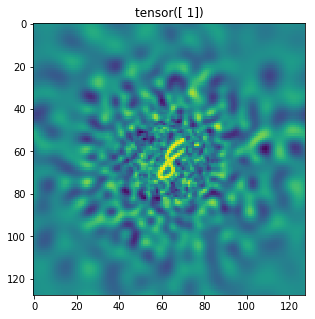

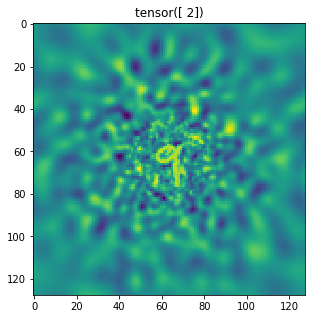

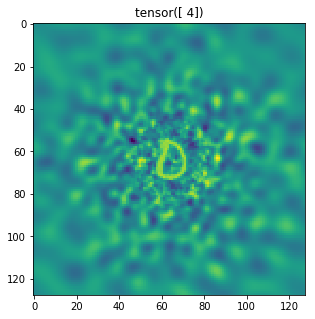

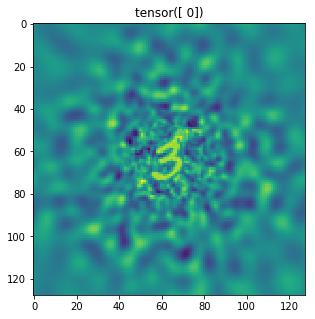

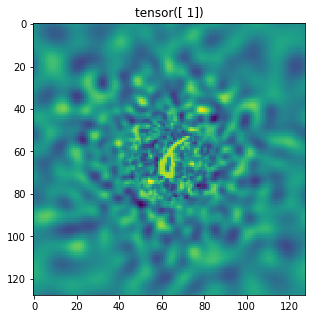

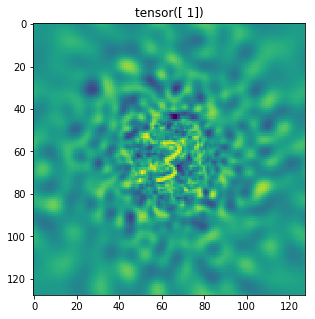

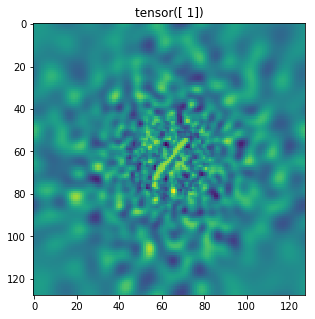

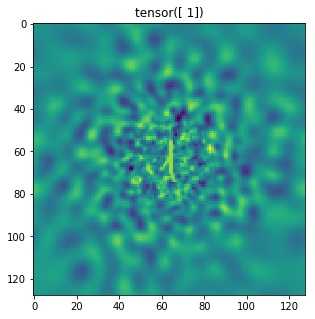

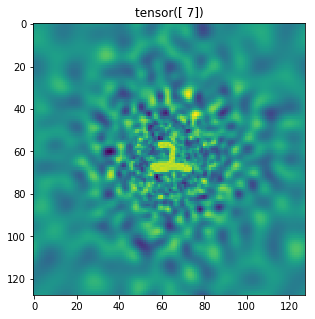

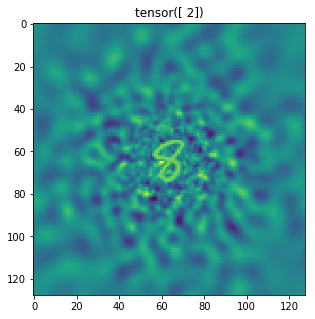

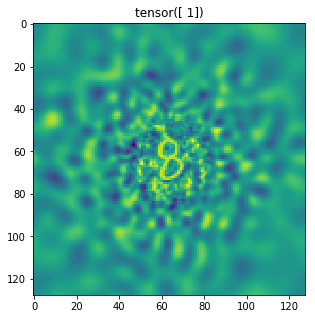

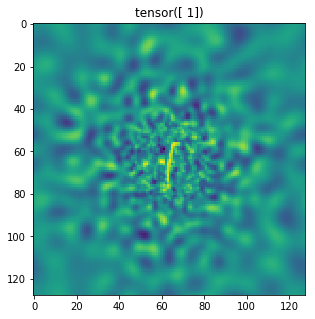

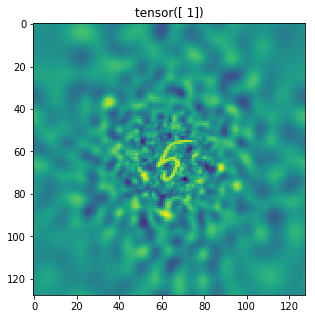

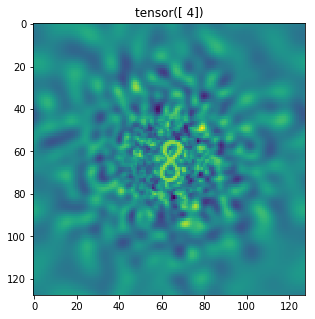

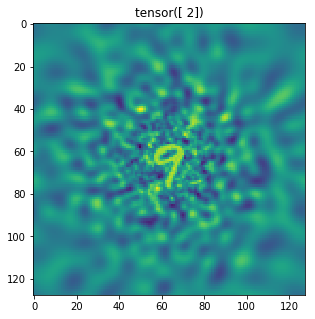

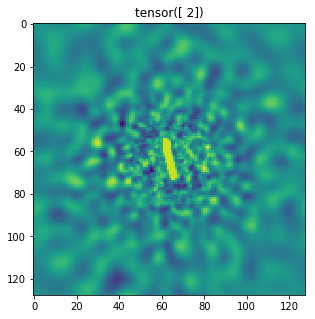

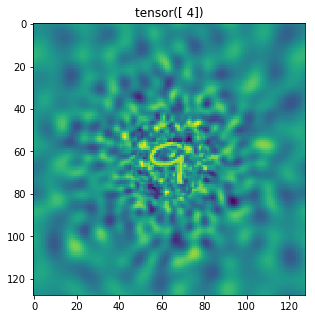

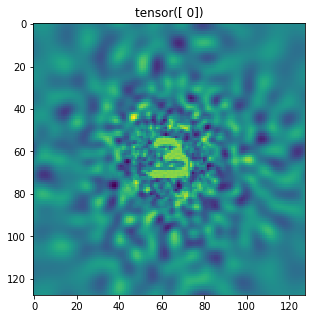

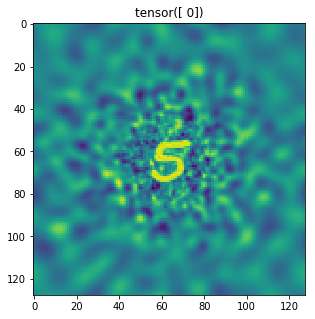

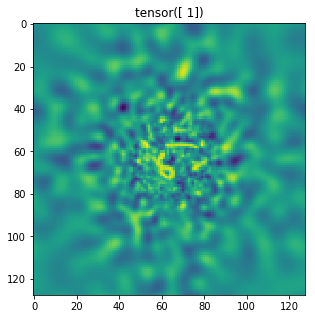

In [257]:
for i in range(20):
    plt.figure(figsize=(5,5))
    im = retina_inverse @ data_retina[i, :]
    plt.imshow(im.reshape(128, 128))
    plt.title(pred[i])

In [ ]:
#### additive noise

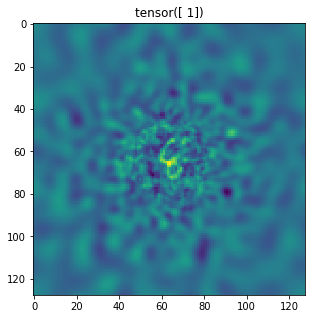

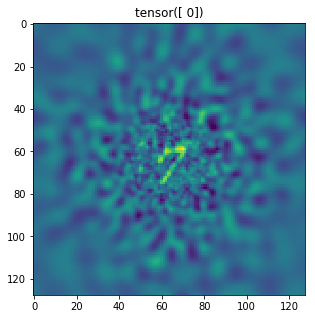

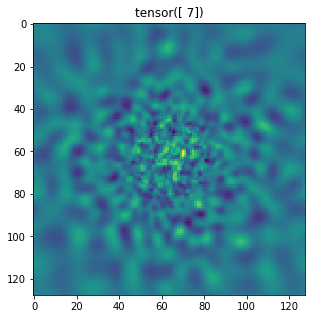

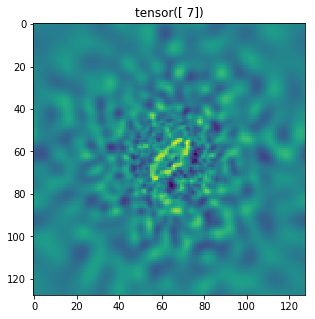

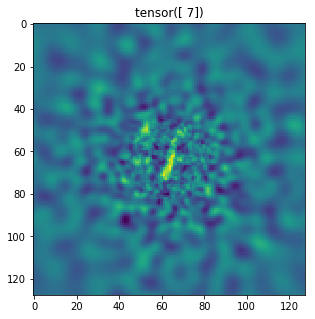

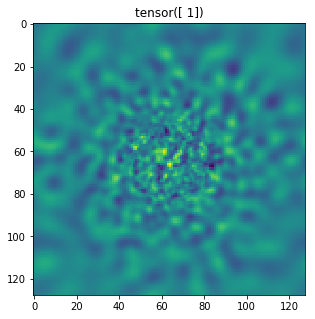

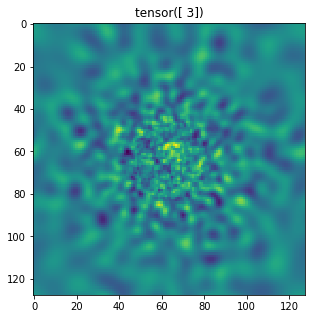

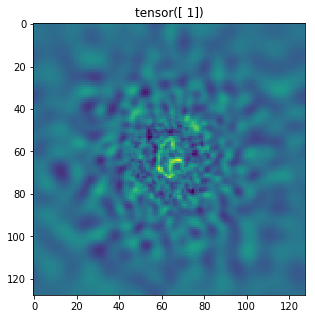

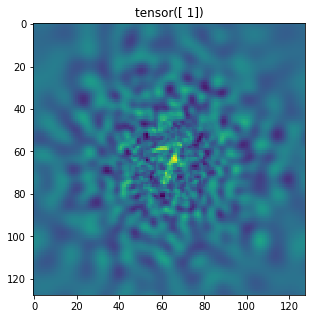

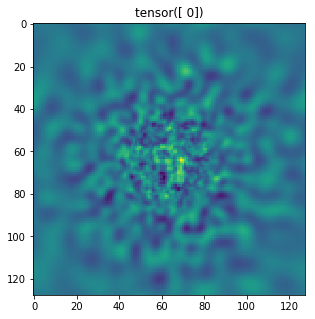

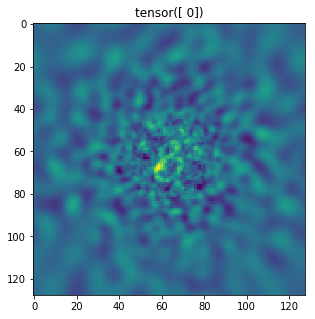

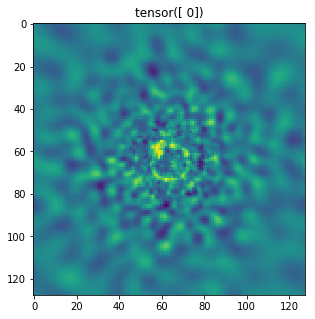

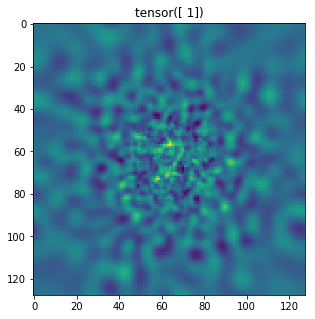

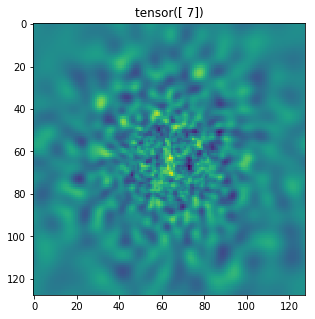

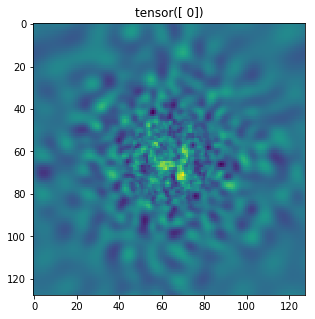

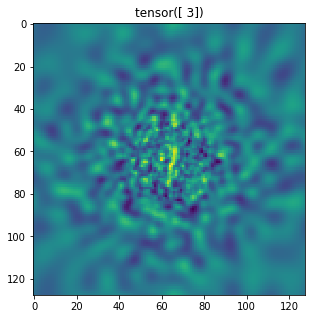

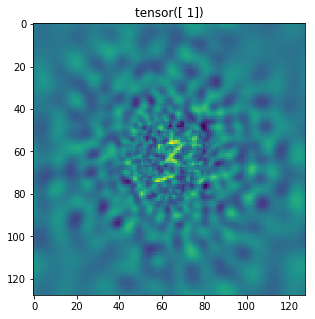

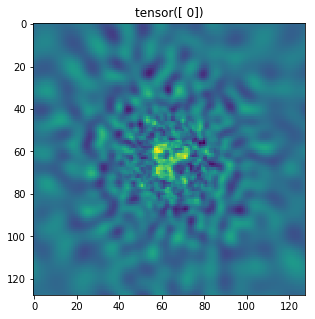

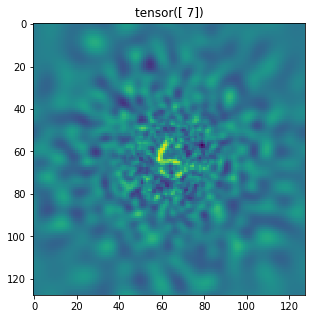

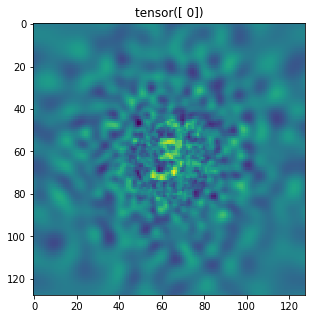

In [222]:
for i in range(20):
    plt.figure(figsize=(5,5))
    im = retina_inverse @ data_retina[i, :]
    plt.imshow(im.reshape(128, 128))
    plt.title(pred[i])

##  Anywhere, no noise

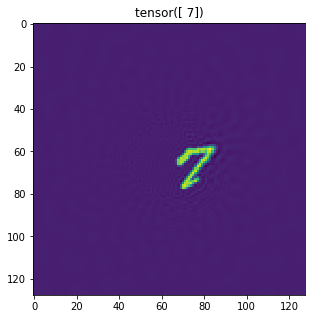

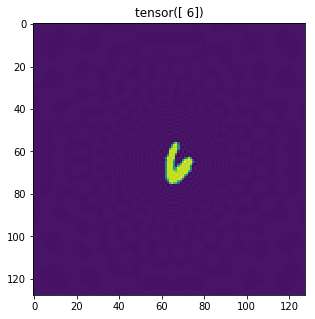

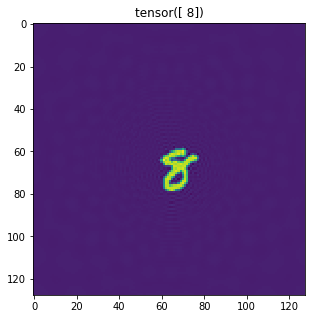

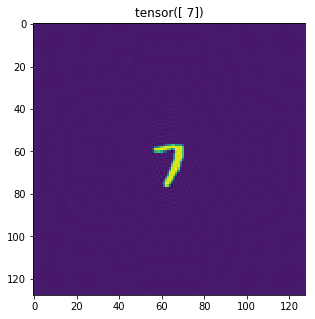

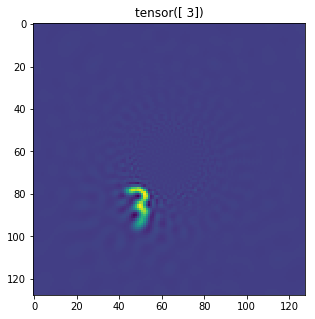

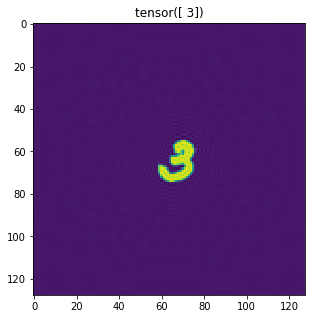

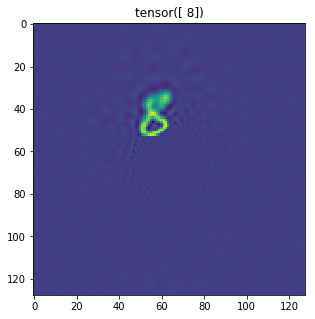

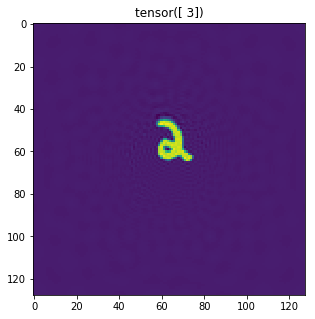

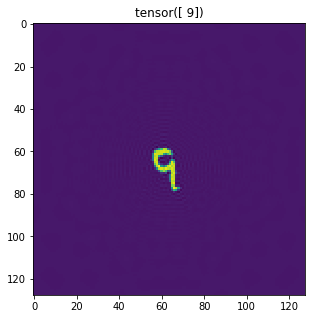

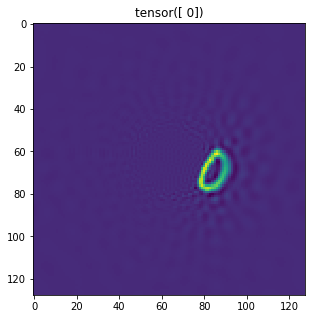

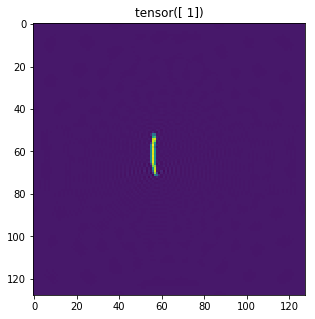

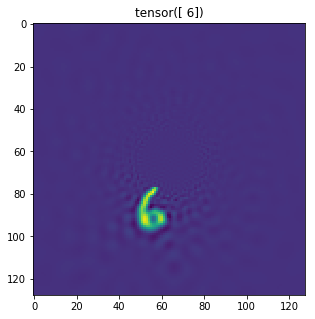

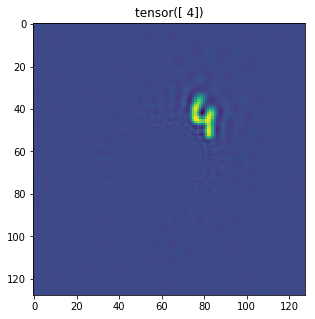

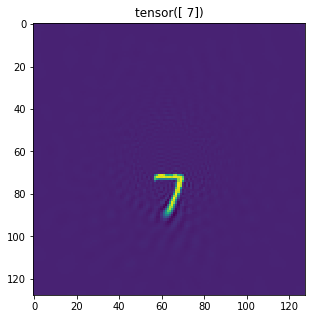

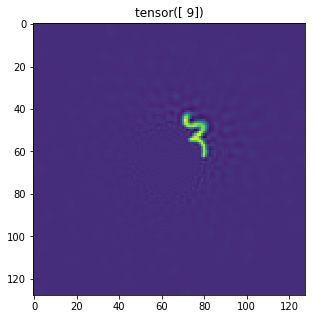

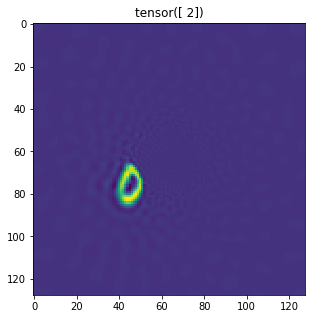

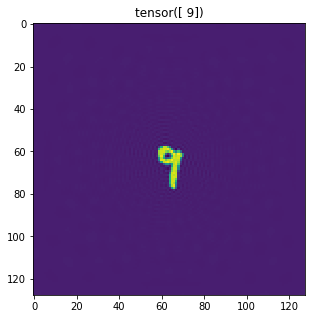

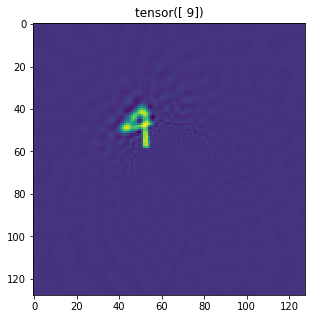

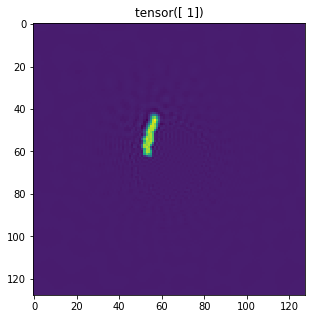

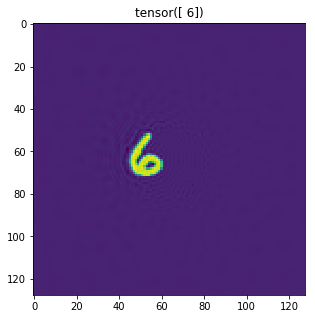

In [204]:
for i in range(20):
    plt.figure(figsize=(5,5))
    im = retina_inverse @ data_retina[i, :]
    plt.imshow(im.reshape(128, 128))
    plt.title(pred[i])

In [161]:
Accuracy = test(net)

In [162]:
Accuracy

0.629